In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 26))
train_y = Variable(torch.sign(torch.cos(train_x.data * (8 * math.pi))))

In [3]:
from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [ ]:
class GPClassificationModel(gpytorch.GPModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
        self.grid_covar_module = GridInterpolationKernel(self.covar_module)
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-6,6))
        self.initialize_interpolation_grid(30, grid_bounds=(0, 1))
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.grid_covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

prior_model = GPClassificationModel()

In [5]:
def plot_model_and_predictions(model, plot_train_data=True):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 100))
    observed_pred = model(test_x)

    def ax_plot(ax, rand_var, title):
        if plot_train_data:
            ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

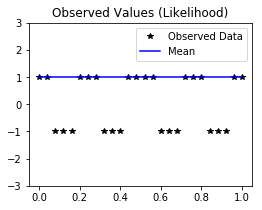

In [6]:
f = plot_model_and_predictions(prior_model, plot_train_data=True)

In [7]:
from gpytorch.inference import Inference
infer = Inference(prior_model)
posterior_model = infer.run(train_x, train_y)

# Find optimal model hyperparameters
posterior_model.train()
optimizer = optim.Adam(posterior_model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(200):
    optimizer.zero_grad()
    output = posterior_model.forward(train_x)
    loss = -posterior_model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/20 - Loss: %.3f   log_lengthscale: %.3f' % (
        i + 1, loss.data[0],
        posterior_model.prior_model.covar_module.log_lengthscale.data.squeeze()[0],
    ))
    optimizer.step()
    
# Set back to eval mode
posterior_model.eval()
None

(Variable containing:
-0.0370
 0.0000
 0.0370
 0.0741
 0.1111
 0.1481
 0.1852
 0.2222
 0.2593
 0.2963
 0.3333
 0.3704
 0.4074
 0.4444
 0.4815
 0.5185
 0.5556
 0.5926
 0.6296
 0.6667
 0.7037
 0.7407
 0.7778
 0.8148
 0.8519
 0.8889
 0.9259
 0.9630
 1.0000
 1.0370
[torch.FloatTensor of size 30]
,)
Iter 1/20 - Loss: 61106.539   log_lengthscale: 0.000


/Users/ruihanwu/playground/gpytorch/gpytorch/kernels/rbf_kernel.py:42: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  grad.mul_(grad_output.transpose(0, 1))


Iter 2/20 - Loss: 48373.992   log_lengthscale: -0.100
Iter 3/20 - Loss: 34988.660   log_lengthscale: -0.196
Iter 4/20 - Loss: 26775.789   log_lengthscale: -0.285
Iter 5/20 - Loss: 21163.891   log_lengthscale: -0.377
Iter 6/20 - Loss: 19820.754   log_lengthscale: -0.469
Iter 7/20 - Loss: 11862.473   log_lengthscale: -0.561
Iter 8/20 - Loss: 10702.567   log_lengthscale: -0.654
Iter 9/20 - Loss: 7073.797   log_lengthscale: -0.746
Iter 10/20 - Loss: 5131.780   log_lengthscale: -0.839
Iter 11/20 - Loss: 10972.894   log_lengthscale: -0.935
Iter 12/20 - Loss: 5757.687   log_lengthscale: -1.030
Iter 13/20 - Loss: 2091.012   log_lengthscale: -1.124
Iter 14/20 - Loss: 4328.825   log_lengthscale: -1.216
Iter 15/20 - Loss: 4204.508   log_lengthscale: -1.311
Iter 16/20 - Loss: 4694.114   log_lengthscale: -1.403
Iter 17/20 - Loss: 1542.469   log_lengthscale: -1.498
Iter 18/20 - Loss: 2634.638   log_lengthscale: -1.583
Iter 19/20 - Loss: 2545.196   log_lengthscale: -1.663
Iter 20/20 - Loss: 813.200  

KeyboardInterrupt: 

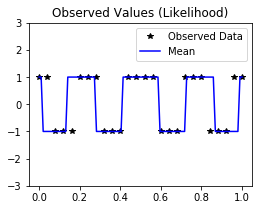

In [8]:
f = plot_model_and_predictions(posterior_model)

In [ ]:
%debug